In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import zipfile

zip_path = "/content/PRAICP-1002-TrafSignDetc.zip"
extract_path = "/content/TrafSignDetc"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
path = "/content/TrafSignDetc/Train"
labelFile = '/content/TrafSignDetc/Train.csv'
batch_size_val=32
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        curImg = cv2.resize(curImg,(imageDimesions[0],imageDimesions[1])) # Resize image to a consistent size
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


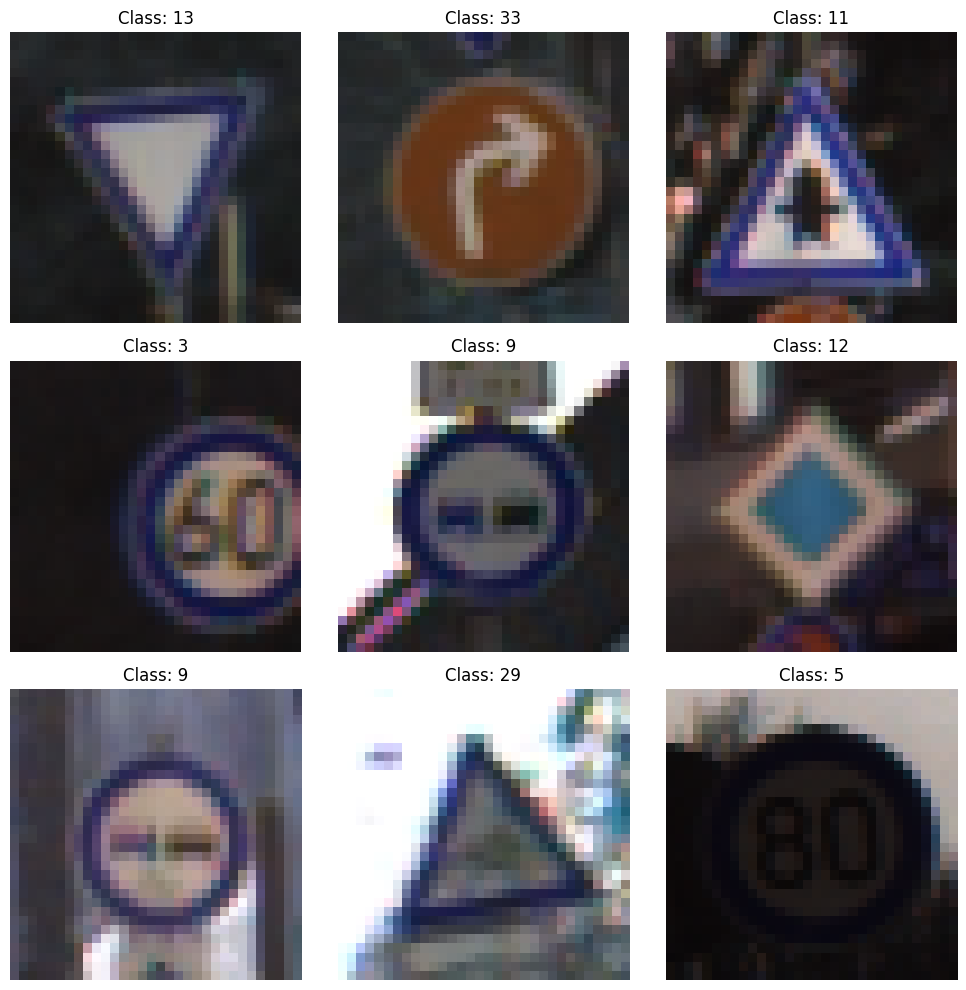

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    # Select a random image from the dataset
    index = random.randint(0, len(images)-1)
    img = images[index]
    class_id = classNo[index]

    plt.subplot(3, 3, i + 1)
    # If the image is grayscale, remove the last dimension for proper display
    if img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    plt.title(f"Class: {class_id}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)


print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)


data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

Data Shapes
Train(25093, 32, 32, 3) (25093,)
Validation(6274, 32, 32, 3) (6274,)
Test(7842, 32, 32, 3) (7842,)
data shape  (39209, 8) <class 'pandas.core.frame.DataFrame'>


In [8]:
num_of_samples = []
cols = 5
num_classes = noOfClasses

def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img


In [15]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)


data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

Data Shapes
Train(25093, 32, 32) (25093,)
Validation(6274, 32, 32) (6274,)
Test(7842, 32, 32) (7842,)
data shape  (39209, 8) <class 'pandas.core.frame.DataFrame'>


In [16]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [17]:
dataGen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)

In [18]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [19]:
def myModel():
    model= Sequential()
    model.add((Conv2D(60,(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(60, (5,5), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add((Conv2D(30, (3,3),activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax'))
    model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [20]:
model = myModel()
print(model.summary())
history=model.fit(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


784/784 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.1749 - loss: 3.0490 - val_accuracy: 0.8326 - val_loss: 0.6843
Epoch 2/10
  1/784 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5625 - loss: 1.3156

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.5625 - loss: 1.3156 - val_accuracy: 0.8349 - val_loss: 0.6745
Epoch 3/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.6168 - loss: 1.2430 - val_accuracy: 0.9350 - val_loss: 0.2591
Epoch 4/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.8125 - loss: 0.6381 - val_accuracy: 0.9337 - val_loss: 0.2653
Epoch 5/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7617 - loss: 0.7640 - val_accuracy: 0.9582 - val_loss: 0.1555
Epoch 6/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9062 - loss: 0.3235 - val_accuracy: 0.9579 - val_loss: 0.1507
Epoch 7/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8178 - loss: 0.5754 - val_accuracy: 0.9587 - val_loss: 0.1376
Epoch 8/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.7812 - loss: 0.5388 - val_accuracy: 0.9576 - val_loss: 0.1367
Epoch 9/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8553 - loss: 0.4676 - val_accurac

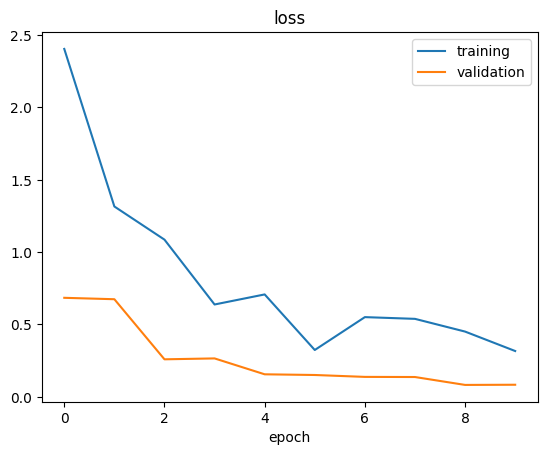

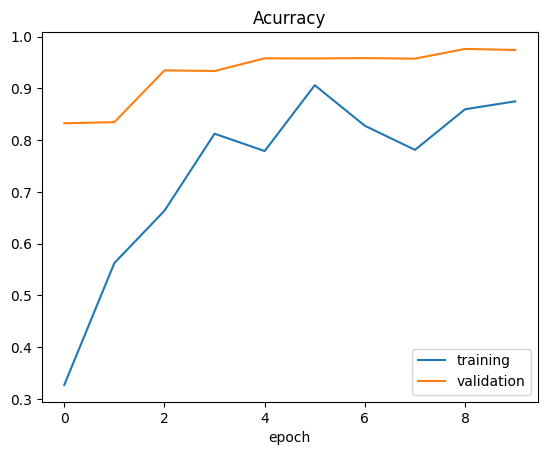

Test Score: 0.0768987238407135
Test Accuracy: 0.974751353263855


In [21]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [22]:
model.save("TrafSignDetc.h5")